In [224]:
!pip3 install matplotlib
!pip3 install numpy
!pip3 install scipy
!pip3 install statsmodels

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [225]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import scipy.interpolate
from statsmodels.distributions.empirical_distribution import ECDF
import math

In [226]:
K = 8152 # number of OFDM subcarriers
title_info = "16qam_" + str(K) + "_subcarriers"
filename = "papr_data_7.dat"

The length of the cyclic prefix (CP) denotes the number of samples that are copied from the end of the modulated block to the beginning, to yield a cyclic extension of the block. There is a dedicated article on the CP of OFDM which treats its application in more detail.

In [227]:
CP = K//4  # length of the cyclic prefix: 25% of the block

The number of pilots P in the OFDM symbol describes, how many carriers are used to transmit known information (i.e. pilots). Pilots will be used at the receiver to estimate the wireless channel between transmitter and receiver. Further, we also define the value that each pilots transmits (which is known to the receiver).

In [228]:
P = 8 # number of pilot carriers per OFDM block
pilotValue = 3+3j # The known value each pilot transmits

Now, let us define some index sets that describe which carriers transmit pilots and which carriers contain payload.

allCarriers:   [   0    1    2 ... 8149 8150 8151]
pilotCarriers: [   0 1019 2038 3057 4076 5095 6114 7133 8151]
dataCarriers:  [   1    2    3 ... 8148 8149 8150]


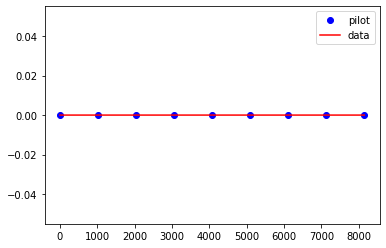

In [229]:
allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])

pilotCarriers = allCarriers[::K//P] # Pilots is every (K/P)th carrier.

# For convenience of channel estimation, let's make the last carriers also be a pilot
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P+1

# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)

print ("allCarriers:   %s" % allCarriers)
print ("pilotCarriers: %s" % pilotCarriers)
print ("dataCarriers:  %s" % dataCarriers)
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'r', label='data')
plt.legend(["pilot", "data"])

Let's define the modulation index μ and the corresponding mapping table. We consider 16QAM transmission, i.e. we have μ=4 bits per symbol. Furthermore, the mapping from groups of 4 bits to a 16QAM constellation symbol shall be defined in mapping_table.

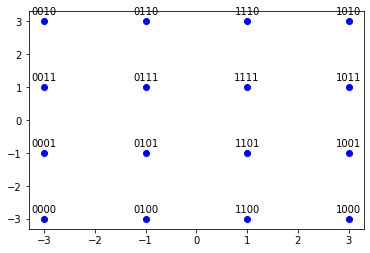

In [230]:
mu = 4 # bits per symbol (i.e. 16QAM)
payloadBits_per_OFDM = len(dataCarriers)*mu  # number of payload bits per OFDM symbol

mapping_table = {
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0) : -3+3j,
    (0,0,1,1) : -3+1j,
    (0,1,0,0) : -1-3j,
    (0,1,0,1) : -1-1j,
    (0,1,1,0) : -1+3j,
    (0,1,1,1) : -1+1j,
    (1,0,0,0) :  3-3j,
    (1,0,0,1) :  3-1j,
    (1,0,1,0) :  3+3j,
    (1,0,1,1) :  3+1j,
    (1,1,0,0) :  1-3j,
    (1,1,0,1) :  1-1j,
    (1,1,1,0) :  1+3j,
    (1,1,1,1) :  1+1j
}
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')

Above, we have plotted the 16QAM constellation, along with the bit-labels. Note the Gray-mapping, i.e. two adjacent constellation symbols differ only by one bit and the other 3 bits remain the same. This technique helps to minimize bit-errors, in case a wrong constellation symbol is detected: Most probably, symbol errors are "off-by-one" errors, i.e. a symbol next to the correct symbol is detected. Then, only a single bit-error occurs.

The demapping table is simply the inverse mapping of the mapping table:

In [231]:
demapping_table = {v : k for k, v in mapping_table.items()}

Let us now define the wireless channel between transmitter and receiver. Here, we use a two-tap multipath channel with given impulse response channelResponse. Also, we plot the corresponding frequency response. As we see, the channel is frequency-selective. Further, we define the signal-to-noise ratio in dB, that should occur at the receiver.

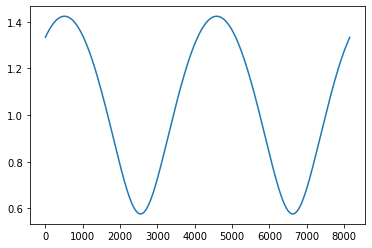

In [232]:
channelResponse = np.array([1, 0, 0.3+0.3j])  # the impulse response of the wireless channel
H_exact = np.fft.fft(channelResponse, K)
plt.plot(allCarriers, abs(H_exact))

SNRdb = 25  # signal to noise-ratio in dB at the receiver 

Now, that we have defined the necessary parameters for our OFDM example, let us consider the blocks in the OFDM system. Reconsider the block diagram:

 

It all starts with a random bit sequence b. We generate the according bits by a random generator that draws from a Bernoulli distribution with p=0.5, i.e. 1 and 0 have equal probability. Note, that the Bernoulli distribution is a special case of the Binomial distribution, when only one draw is considered (n=1):

In [233]:
# input: integer (start_code)
# returns:  integer generated with a basic implementation for prbs31 with monic polynomial: x31 + x28 + 1
def prbs31(start_code):
    for i in range(32):
        next_bit = ~((start_code>>30) ^ (start_code>>27))&0x01
        result_code = ((start_code<<1) | next_bit) & 0xFFFFFFFF
    return result_code

# converts an integer to a bitfield
def bitfield(n):
    return [1 if digit=='1' else 0 for digit in bin(n)[2:]] # [2:] to chop off the "0b" part 


print("payload bits per OFDM: " + str(payloadBits_per_OFDM))

# create a bitfield via the prbs31 function by concatenating smaller bitfields
# start prbs31 with a random integer
bits_int = prbs31(np.random.randint(0, 2048))
bits = bitfield(bits_int)
while (len(bits) < payloadBits_per_OFDM):
    bits_int = prbs31(bits_int)
    bits = bits + bitfield(bits_int)


# truncate bitfield to the exact length required
bits = bits[:payloadBits_per_OFDM]

# convert the list to a numpy.ndarray
bits = np.asarray(bits)

## OTHER METHOD ##
#bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))

print ("Bits count: ", len(bits))
print ("First 20 bits: ", bits[:20])
print ("Mean of bits (should be around 0.5 for binomial distribution with p=0.5): ", np.mean(bits))

payload bits per OFDM: 32572
Bits count:  32572
First 20 bits:  [1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1]
Mean of bits (should be around 0.5 for binomial distribution with p=0.5):  0.5427053911334889


The bits are now sent to a serial-to-parallel converter, which groups the bits for the OFDM frame into a groups of mu bits (i.e. one group for each subcarrier):

In [234]:
def SP(bits):
    return bits.reshape((len(dataCarriers), mu))
bits_SP = SP(bits)
print ("First 5 bit groups")
print (bits_SP[:5,:])

First 5 bit groups
[[1 1 1 1]
 [1 0 0 1]
 [1 1 1 1]
 [1 1 1 1]
 [0 0 1 1]]


Now, the bits groups are sent to the mapper. The mapper converts the groups into complex-valued constellation symbols according to the mapping_table.

In [235]:
def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM = Mapping(bits_SP)
print ("First 5 QAM symbols and bits:")
print (bits_SP[:5,:])
print (QAM[:5])

First 5 QAM symbols and bits:
[[1 1 1 1]
 [1 0 0 1]
 [1 1 1 1]
 [1 1 1 1]
 [0 0 1 1]]
[ 1.+1.j  3.-1.j  1.+1.j  1.+1.j -3.+1.j]


The next step (which is not shown in the diagram) is the allocation of different subcarriers with data and pilots. For each subcarrier we have defined wether it carries data or a pilot by the arrays dataCarriers and pilotCarriers. Now, to create the overall OFDM data, we need to put the data and pilots into the OFDM carriers:

In [236]:
def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers 
    symbol[dataCarriers] = QAM_payload  # allocate the pilot subcarriers
    return symbol
OFDM_data = OFDM_symbol(QAM)
print ("Number of OFDM carriers in frequency domain: ", len(OFDM_data))

Number of OFDM carriers in frequency domain:  8152


Now, the OFDM carriers contained in OFDM_data can be transformed to the time-domain by means of the IDFT operation.

In [237]:
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
OFDM_time = IDFT(OFDM_data)
print ("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))

Number of OFDM samples in time-domain before CP:  8152


In [251]:
# OFDM_time is one OFDM symbol which corresponds to one PAPR value

# compute the PAPR of the time-domain signal
power_peak = max(np.square(abs(OFDM_time)))
power_mean = np.mean(np.square(abs(OFDM_time)), dtype=np.float64)

# decibel above average power
PAPR = 10* np.log10(power_peak / power_mean)

print("PAPR of symbol: " + str(PAPR) + " dB")

PAPR of symbol: 15.348997901671762 dB


Now, we save the resulting PAPR Matrix to a file for further processing.

In [239]:
## todo -- save to file
my_file = open(filename, "w")
my_file.write(title_info + "\n")
my_file.writelines([str(value) + "\n" for value in PAPR])
my_file.close()

Subsequently, we add a cyclic prefix to the symbol. This operation concatenates a copy of the last CP samples of the OFDM time domain signal to the beginning. This way, a cyclic extension is achieved. The CP fulfills two tasks:

It isolates different OFDM blocks from each other when the wireless channel contains multiple paths, i.e. is frequency-selective.
It turns the linear convolution with the channel into a circular one. Only with a circular convolution, we can use the single-tap equalization OFDM is so famous for.
For more information about the CP, you can refer to a dedicated article about the Cyclic Prefix in OFDM.

In [240]:
def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning
OFDM_withCP = addCP(OFDM_time)
print ("Number of OFDM samples in time domain with CP: ", len(OFDM_withCP))

Number of OFDM samples in time domain with CP:  10190


Now, the signal is sent to the antenna and sent over the air to the receiver. In between both antennas, there is the wireless channel. We model this channel as a static multipath channel with impulse response channelResponse. Hence, the signal at the receive antenna is the convolution of the transmit signal with the channel response. Additionally, we add some noise to the signal according to the given SNR value:

RX Signal power: 0.0013. Noise power: 0.0000


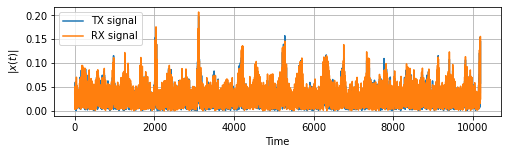

In [241]:
def channel(signal):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR
    
    print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise
OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX)
plt.figure(figsize=(8,2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel('Time'); plt.ylabel('$|x(t)|$');
plt.grid(True);

Now, at the receiver the CP is removed from the signal and a window of K samples is extracted from the received signal.

In [242]:
def removeCP(signal):
    return signal[CP:(CP+K)]
OFDM_RX_noCP = removeCP(OFDM_RX)

Afterwards, the signal is transformed back to the frequency domain, in order to have the received value on each subcarrier available.

In [243]:
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)
OFDM_demod = DFT(OFDM_RX_noCP)

As the next step, the wireless channel needs to be estimated. For illustration purposes, we resort to a simple zero-forcing channel estimation followed by a simple interpolation. The principle of channel estimation is as follows:

The transmit signal contains pilot values at certain pilot carriers. These pilot values and their position in the frequency domain (i.e. the pilot carrier index) are known to the receiver. From the received information at the pilot subcarriers, the receiver can estimate the effect of the wireless channel onto this subcarrier (because it knows what was transmitted and what was received). Hence, the receiver gains information about the wireless channel at the pilot carriers. However, it wants to know what happened at the data carriers. To achieve this, it interpolates the channel values between the pilot carriers to get an estimate of the channel in the data carriers.

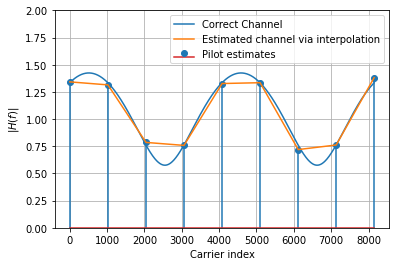

In [244]:
def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values
    
    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase 
    # separately
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    
    plt.plot(allCarriers, abs(H_exact), label='Correct Channel')
    plt.stem(pilotCarriers, abs(Hest_at_pilots), label='Pilot estimates')
    plt.plot(allCarriers, abs(Hest), label='Estimated channel via interpolation')
    plt.grid(True); plt.xlabel('Carrier index'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=10)
    plt.ylim(0,2)
    
    return Hest
Hest = channelEstimate(OFDM_demod)

Now that the channel is estimated at all carriers, we can use this information in the channel equalizer step. Here, for each subcarrier, the influence of the channel is removed such that we get the clear (only noisy) constellation symbols back.

In [245]:
def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest
equalized_Hest = equalize(OFDM_demod, Hest)

The next step (not shown in the diagram) is to extract the data carriers from the equalized symbol. Here, we throw away the pilot carriers, as they do not provide any information, but were used for the channel estimation process.

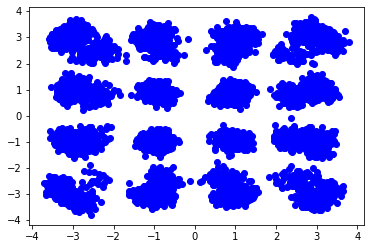

In [246]:
def get_payload(equalized):
    return equalized[dataCarriers]
QAM_est = get_payload(equalized_Hest)
plt.plot(QAM_est.real, QAM_est.imag, 'bo');

Now, that the constellation is obtained back, we need to send the complex values to the demapper, to transform the constellation points to the bit groups. In order to do this, we compare each received constellation point against each possible constellation point and choose the constellation point which is closest to the received point. Then, we return the bit-group that belongs to this point.

In [247]:
def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # for each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    
    # get back the real constellation point
    hardDecision = constellation[const_index]
    
    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

PS_est, hardDecision = Demapping(QAM_est)
for qam, hard in zip(QAM_est, hardDecision):
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o');
    plt.plot(hardDecision.real, hardDecision.imag, 'ro')

MemoryError: Unable to allocate 127. KiB for an array with shape (8143, 2) and data type float64

MemoryError: In RendererAgg: Out of memory

<Figure size 432x288 with 1 Axes>

In the diagram above, the blue points are the received QAM points, where as the the red points connected to them are the closest possible constellation points, and the bit groups corresponding to these red points are returned.

Finally, the bit groups need to be converted to a serial stream of bits, by means of parallel to serial conversion.

In [ ]:
def PS(bits):
    return bits.reshape((-1,))
bits_est = PS(PS_est)

Now, that all bits are decoded, let's calculate the bit error rate:

In [ ]:
print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_est))/len(bits))

Obtained Bit error rate:  0.000980872976949485


Fortunately, no bit error occured and the transmission was successful (Reduce the SNR to get some bit errors)